## Basic Cleaning

In [810]:
import pandas as pd


In [811]:
df = pd.read_excel('/Users/thananpornsethjinda/Desktop/internship/projects/in-progress/sigma-education/data/สถิติจำนวนการเกิด_พื้นที่ ทั่วประเทศ_.xlsx')

In [812]:
df

,สถิติจำนวนการเกิด,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,พื้นที่ ทั่วประเทศ,NaN,NaN,NaN
1,ข้อมูลเดือน มกราคม 2545 ถึงเดือน สิงหาคม 2568,NaN,NaN,NaN
2,พื้นที่,ชาย,หญิง,รวม
3,ยอดรวมทั้งหมด,8566049,8068441,16634490
4,มกราคม 2545,34114,32043,66157
...,...,...,...,...
283,เมษายน 2568,17982,16975,34957
284,พฤษภาคม 2568,17596,16415,34011
285,มิถุนายน 2568,16482,15763,32245
286,กรกฎาคม 2568,17886,16685,34571


In [813]:
def miscalleneous_formatting(df): 
    
    df = df.copy()

    df.dropna(inplace=True)

    df.drop([2, 3], inplace=True)

    df.columns = ['full_date', 'male', 'female', 'total']

    df[['month', 'thai_year']] = df['full_date'].str.split(' ', n=1, expand=True)

    df['thai_year'] = df['thai_year'].astype(int)

    df['standard_year'] = df['thai_year'] - 543

    thai_to_english_months = {
    'มกราคม': 'january',
    'กุมภาพันธ์': 'february',
    'มีนาคม': 'march',
    'เมษายน': 'april',
    'พฤษภาคม': 'may',
    'มิถุนายน': 'june',
    'กรกฎาคม': 'july',
    'สิงหาคม': 'august',
    'กันยายน': 'september',
    'ตุลาคม': 'october',
    'พฤศจิกายน': 'november',
    'ธันวาคม': 'december'

    }

    df['month'] = df['month'].map(thai_to_english_months)

    df['date_time'] = pd.to_datetime(
    df['month'] + '-' + df['standard_year'].astype(str),
    format='%B-%Y')

    df.drop('full_date', axis=1, inplace=True)

    df['total'] = df['total'].astype(int)

    df.drop(['male', 'female', 'thai_year'], inplace=True, axis=1)

    return df


In [814]:
formatted_df = miscalleneous_formatting(df)

In [815]:
formatted_df

,total,month,standard_year,date_time
4,66157,january,2002,2002-01-01
5,55078,february,2002,2002-02-01
6,62499,march,2002,2002-03-01
7,65166,april,2002,2002-04-01
8,66098,may,2002,2002-05-01
...,...,...,...,...
283,34957,april,2025,2025-04-01
284,34011,may,2025,2025-05-01
285,32245,june,2025,2025-06-01
286,34571,july,2025,2025-07-01


## Visualisations 

In [816]:
import matplotlib.pyplot as plt
import plotly.express as px

In [817]:
fig = px.line(formatted_df, x=formatted_df['date_time'], y=formatted_df['total'])

fig.show()

## Preprocessing

In [818]:

formatted_df = formatted_df.set_index('date_time')


In [819]:
def create_features(df): 
    """
    Create time series features based on time series index.
    """

    df = df.copy()

    df['quarter'] = df.index.quarter 
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df 

In [820]:
processed_df = create_features(formatted_df)

In [821]:
def add_lags(df):

    target_map = df['total'].to_dict()

    df['lag2'] = (df.index - pd.DateOffset(months=1)).map(target_map)

    df['lag3'] = (df.index - pd.DateOffset(months=2)).map(target_map)

    return df 

In [822]:
pre_processed_df = add_lags(processed_df)

## Time Series Cross Validation Visualisation

In [823]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=12, gap=0)
pre_processed_df = pre_processed_df.sort_index()

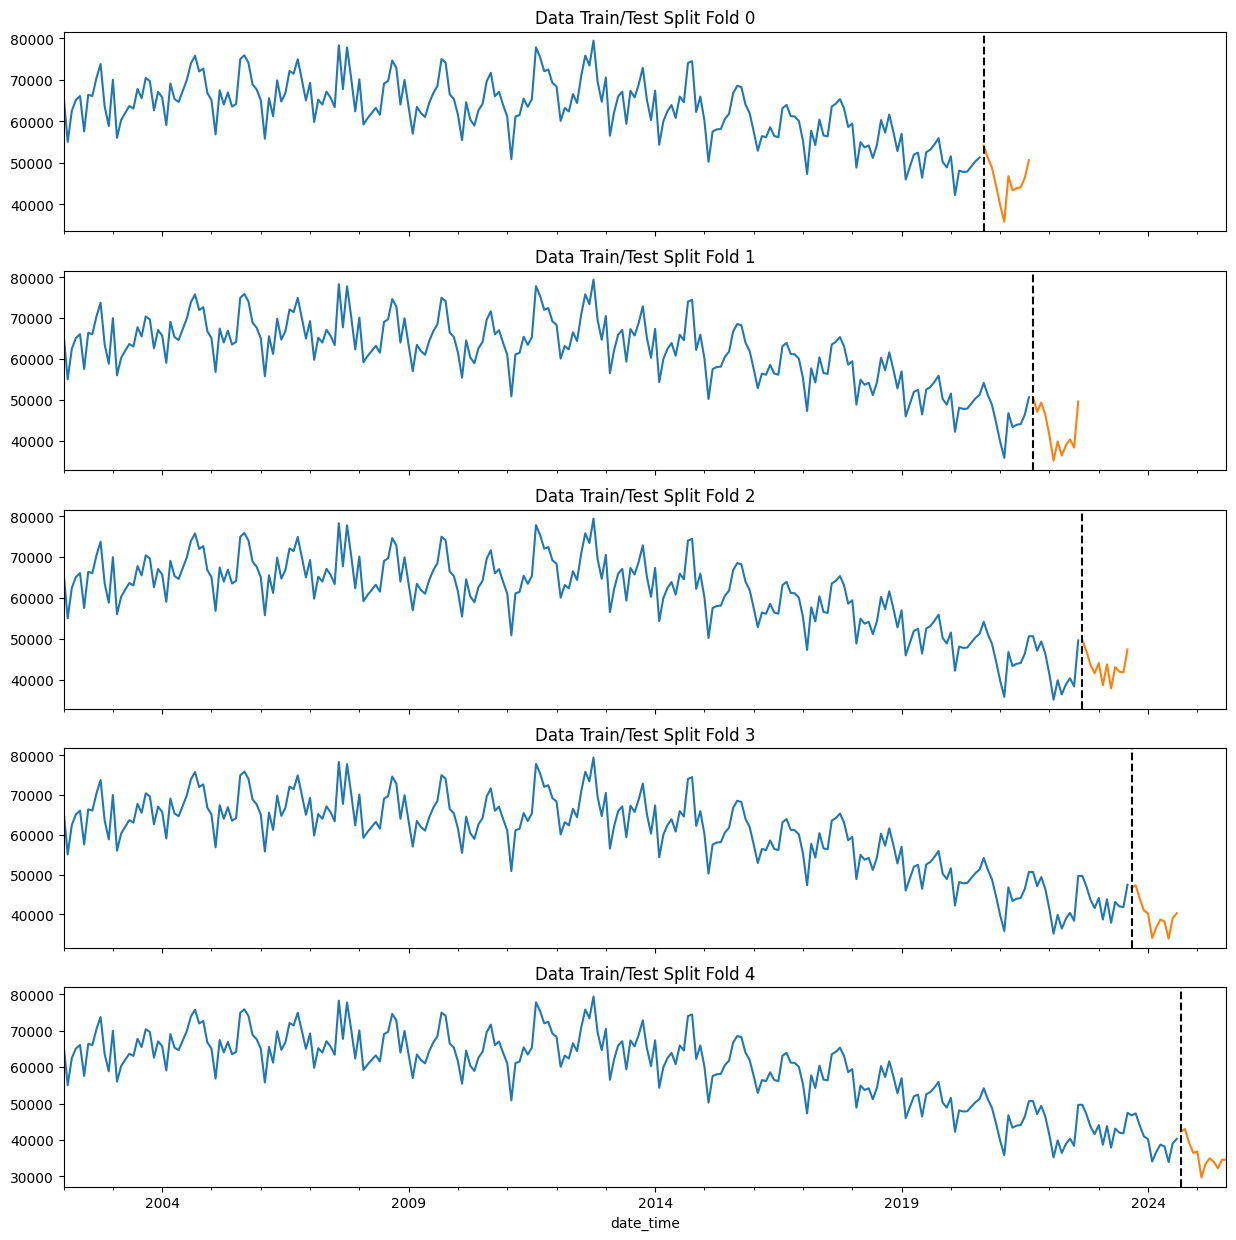

In [824]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0 

for train_idx, test_idx in tss.split(pre_processed_df): 
    train = pre_processed_df.iloc[train_idx]
    test = pre_processed_df.iloc[test_idx]
    train['total'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['total'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Training

In [825]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Assuming your DataFrame 'df' has a datetime index and 'total' column
pre_processed_df['year'] = pre_processed_df.index.year

# Create a linear model to capture the trend
trend_model = LinearRegression()

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(pre_processed_df[['year']])
trend_model.fit(X_poly, pre_processed_df['total'])

# Predict the trend for the entire dataset
pre_processed_df['trend_pred'] = trend_model.predict(X_poly)

In [826]:
pre_processed_df['residuals'] = pre_processed_df['total'] - pre_processed_df['trend_pred']

In [ ]:
import xgboost as xgb
import numpy as np 
from sklearn.metrics import root_mean_squared_error

def time_series_score(df, model): 

        fold = 0 
        preds = []
        scores = []

        for train_idx, val_idx in tss.split(df): 
                train = df.iloc[train_idx]
                test = df.iloc[val_idx]

                FEATURES = ['month', 'quarter', 'year', 'dayofyear', 'lag2', 'lag3']

                TARGET = 'residuals'

                X_train = train[FEATURES]

                y_train = train[TARGET]

                X_test = test[FEATURES]

                y_test = test[TARGET]
        
                model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=False)
        
                y_pred = model.predict(X_test)
                preds.append(y_pred)

                score = root_mean_squared_error(y_test, y_pred) 

                scores.append(score)
        
        print(scores)
        
        return np.mean(scores)


In [828]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                n_estimators=1000,
                                early_stopping_rounds=50,
                                objective='reg:linear',
                                max_depth=3,
                                learning_rate=0.01)

time_series_score(df=pre_processed_df, model=model)

/Users/thananpornsethjinda/miniconda3/envs/grass/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning:

[14:42:39] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.

/Users/thananpornsethjinda/miniconda3/envs/grass/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning:

[14:42:39] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.

/Users/thananpornsethjinda/miniconda3/envs/grass/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning:

[14:42:40] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squa

[3277.399778897167, 2776.880963509587, 2967.4601649006613, 1817.5332597863892, 1491.4231256535613]


np.float64(2466.139458549473)

## Hyperparameter Fine Tuning

In [ ]:
import optuna 

from optuna import Trial 

def objective(trial: Trial): 

    max_depth = trial.suggest_int('max_depth',low=3, high=10)

    n_estimators = trial.suggest_int('n_estimators',low=500, high=1000)

    learning_rate = trial.suggest_float('learning_rate',low=0.01, high=0.1)

    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=n_estimators,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=max_depth,
                           learning_rate=learning_rate,
                           verbose=False)
    
    return time_series_score(df=pre_processed_df, model=model)

In [844]:
study = optuna.create_study(direction='maximize')

[I 2025-09-14 14:43:11,651] A new study created in memory with name: no-name-dcaba89b-b73c-41ad-879d-25326ebb443e


In [ ]:
study.optimize(objective, n_trials=20)

In [832]:
study.best_params

{'max_depth': 9, 'n_estimators': 978, 'learning_rate': 0.07294223861139097}

## Final Model 

In [834]:
FEATURES = ['month', 'quarter', 'year', 'dayofyear', 'lag2', 'lag3']

TARGET = 'residuals'

X_all = pre_processed_df[FEATURES]
y_all = pre_processed_df[TARGET]

final = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=978,
                       objective='reg:linear',
                       max_depth=9,
                       learning_rate=0.07294223861139097,
                       reg_lambda = 0.3)
final.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:4513.42199


/Users/thananpornsethjinda/miniconda3/envs/grass/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[14:42:41] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.



[100]	validation_0-rmse:54.70559
[200]	validation_0-rmse:4.63708
[300]	validation_0-rmse:0.54108
[400]	validation_0-rmse:0.08853
[500]	validation_0-rmse:0.01166
[600]	validation_0-rmse:0.00392
[700]	validation_0-rmse:0.00336
[800]	validation_0-rmse:0.00337
[900]	validation_0-rmse:0.00336
[977]	validation_0-rmse:0.00336


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07294223861139097, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=978, n_jobs=None,
             num_parallel_tree=None, ...)

## Prediction

In [835]:
future = pd.date_range('2025-08-01','2027-08-01', freq='MS')
future_df = pd.DataFrame(index=future)


In [836]:
future_df['isFuture'] = True
pre_processed_df['isFuture'] = False
df_and_future = pd.concat([pre_processed_df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [837]:
future_w_features = df_and_future.query('isFuture').copy()


In [838]:
future_w_features

,total,month,standard_year,quarter,year,dayofyear,lag2,lag3,trend_pred,residuals,isFuture
2025-08-01,NaN,8,NaN,3,2025,213,34571.0,32245.0,NaN,NaN,True
2025-09-01,NaN,9,NaN,3,2025,244,NaN,34571.0,NaN,NaN,True
2025-10-01,NaN,10,NaN,4,2025,274,NaN,NaN,NaN,NaN,True
2025-11-01,NaN,11,NaN,4,2025,305,NaN,NaN,NaN,NaN,True
2025-12-01,NaN,12,NaN,4,2025,335,NaN,NaN,NaN,NaN,True
2026-01-01,NaN,1,NaN,1,2026,1,NaN,NaN,NaN,NaN,True
2026-02-01,NaN,2,NaN,1,2026,32,NaN,NaN,NaN,NaN,True
2026-03-01,NaN,3,NaN,1,2026,60,NaN,NaN,NaN,NaN,True
2026-04-01,NaN,4,NaN,2,2026,91,NaN,NaN,NaN,NaN,True
2026-05-01,NaN,5,NaN,2,2026,121,NaN,NaN,NaN,NaN,True


In [839]:
future_w_features['pred'] = final.predict(future_w_features[FEATURES])


In [840]:
future_df['trend_pred'] = trend_model.predict(poly.transform(future_w_features[['year']]))


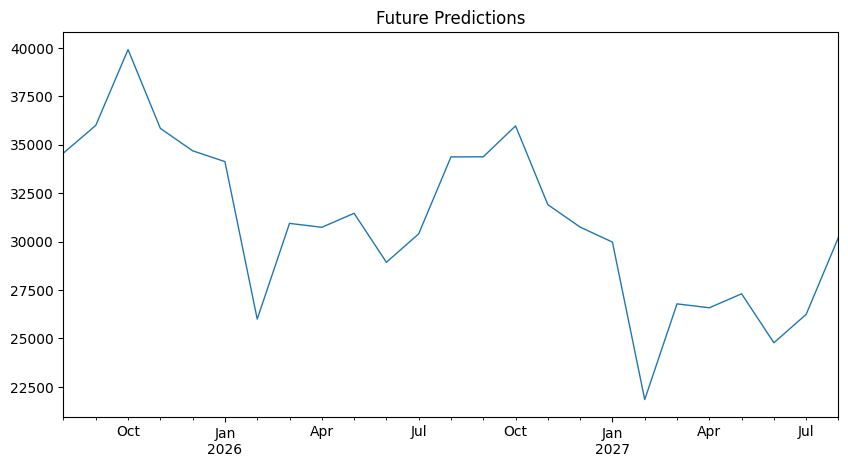

In [841]:
(future_w_features['pred']+future_df['trend_pred']).plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

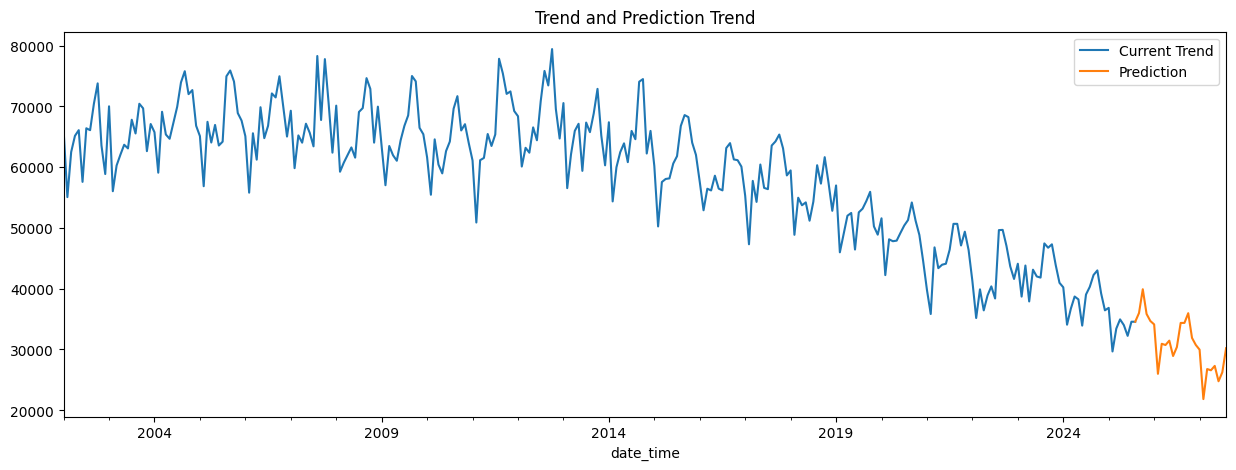

In [845]:
fig, ax = plt.subplots(figsize=(15, 5))
pre_processed_df['total'].plot(ax=ax, label='Training Set', title='Trend and Prediction Trend')
(future_w_features['pred']+future_df['trend_pred']).plot(ax=ax, label='Predictions')
ax.legend(['Current Trend', 'Prediction'])
plt.show()

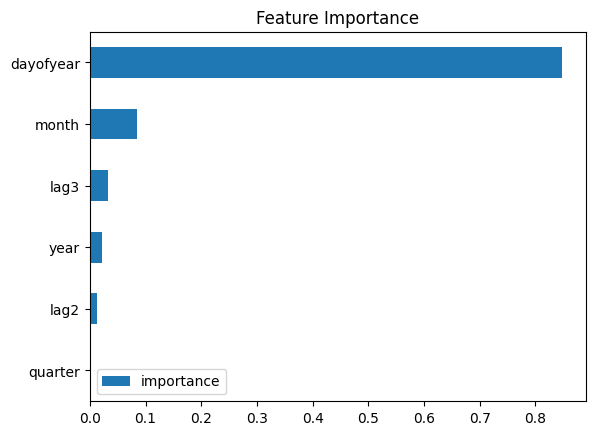

In [843]:
fi = pd.DataFrame(data=final.feature_importances_,
             index=final.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()